# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn

plt.style.use("seaborn-v0_8-paper")
import numpy as np
import torch

In [3]:
from polcanet import LinearDecoder, PolcaNet
from polcanet.example_aencoders import (
    StandardScalerTorch,
    autoencoder_factory,
    generate_2d_sinusoidal_data,
)

In [4]:
from polcanet.polcanet_reports import (
    analyze_latent_feature_importance,
    analyze_latent_space,
    analyze_reconstruction_error,
    linearity_tests_analysis,
    orthogonality_test_analysis,
    plot_cumsum_variance,
    plot_scatter_corr_matrix,
    plot_stdev_pct,
    show_correlation_matrix,
    variance_test_analysis,
)

In [5]:
np.random.seed(5)

In [6]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

## PolcaNet on Synthetic Sinudosial Images

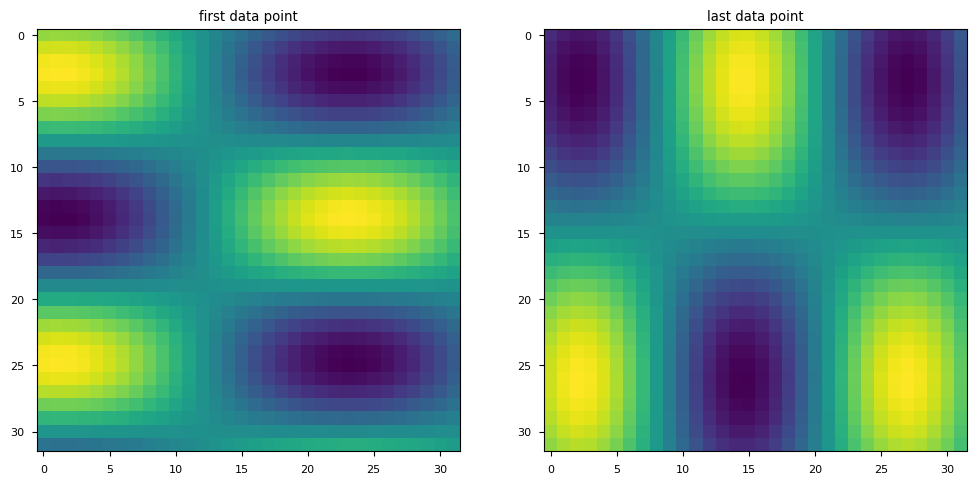

In [7]:
# Parameters
N = 32  # Sequence length
M = 32  # Number of features
num_samples = 1000

# Generate 2D sinusoidal data
data = generate_2d_sinusoidal_data(N, M, num_samples)
data.shape
# Plot original and reconstructed signals for a sample
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(data[0], cmap="viridis")
axes[0].set_title("first data point")
axes[1].imshow(data[-1], cmap="viridis")
axes[1].set_title("last data point")
plt.show()

## Create the POLCA-Net

### Create a POLCA-Net with an LSTM Encoder

In [8]:
ae_input = data
act_fn = torch.nn.Mish()
input_dim = ae_input[0].shape
latent_dim = 256
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"

encoder_lstm = autoencoder_factory(
    seq_len=input_dim[0],  #    N
    input_dim=input_dim[1],  #  M
    latent_dim=256,
    hidden_dim=None,
    num_layers=2,
    autoencoder_type="lstm",
    act_fn=act_fn,
)

decoder_lstm = LinearDecoder(latent_dim=latent_dim, input_dim=input_dim, hidden_dim=256, num_layers=3)

model_lstm = PolcaNet(
    encoder=encoder_lstm,
    decoder=decoder_lstm,
    latent_dim=latent_dim,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
    scaler=StandardScalerTorch(),
)
model_lstm

PolcaNet(
  (encoder): LSTMAutoencoder(
    (encoder): LSTMEncoder(
      (lstm): LSTM(32, 256, num_layers=2, batch_first=True)
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): NoActivation()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): NoActivation()
      (4): Linear(in_features=256, out_features=1024, bias=True)
    )
  )
  (polcanet_loss): PolcaNetLoss()
)

In [9]:
model_lstm.to_device("cuda:3")
model_lstm.train_model(data=data, batch_size=512, num_epochs=10000, report_freq=10, lr=1e-3, use_two_decoders=True)

TypeError: PolcaNet.train_model() got an unexpected keyword argument 'use_two_decoders'

In [ ]:
model_lstm.train_model(data=data, batch_size=512, num_epochs=1000, report_freq=10, lr=1e-4, use_two_decoders=True)

In [ ]:
analyze_reconstruction_error(model_lstm, data, n_samples=1000)

In [ ]:
latents, reconstructed = model_lstm.predict(data)
data.shape, reconstructed.shape, latents.shape

In [ ]:
# Plot original and reconstructed signals for a sample
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(data[0], cmap="viridis")
axes[0].set_title("Original")
axes[1].imshow(reconstructed[0], cmap="viridis")
axes[1].set_title("Reconstructed")
plt.show()

In [ ]:
analyze_latent_space(model_lstm, data=data)

In [ ]:
orthogonality_test_analysis(model_lstm, data)

In [ ]:
variance_test_analysis(model_lstm, data)

In [ ]:
linearity_tests_analysis(model_lstm, data)

---

### Create a POLCA-Net with a 2D Convolutional Encoder

In [10]:
ae_input = data
act_fn = torch.nn.SiLU
input_dim = ae_input[0].shape
latent_dim = 64
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"

encoder_conv = autoencoder_factory(
    seq_len=input_dim[0],  #    N
    input_dim=input_dim[1],  #  M
    latent_dim=latent_dim,
    hidden_dim=None,
    num_layers=None,
    autoencoder_type="conv2d",
    act_fn=act_fn,
)

decoder_conv = LinearDecoder(latent_dim=latent_dim * 4, 
                             input_dim=input_dim,
                             hidden_dim=1024,
                             num_layers=2)

model_conv = PolcaNet(
    encoder=encoder_conv,
    decoder=decoder_conv,
    latent_dim=latent_dim * 4,
    alpha=1.0,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
    # scaler=StandardScalerTorch(),
)
model_conv

PolcaNet(
  (encoder): ConvAutoencoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): SiLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): SiLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): SiLU()
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): SiLU()
      (8): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): NoActivation()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
    )
  )
  (polcanet_loss): PolcaNetLoss()
)

In [11]:
model_conv.to("cuda:3")
model_conv.train_model(data=data, batch_size=512, num_epochs=10000, report_freq=10, lr=1e-3)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
Total Loss: 0.001506
Reconstruction Loss: 0.0001484
Orthogonality Loss: 0.001238
Center of Mass Loss: 7.938e-05
Variance Distribution Loss: 4.009e-05


In [12]:
model_conv.train_model(data=data, batch_size=512, num_epochs=10000, report_freq=10, lr=1e-4)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
Total Loss: 0.001248
Reconstruction Loss: 5.734e-05
Orthogonality Loss: 0.001113
Center of Mass Loss: 4.097e-05
Variance Distribution Loss: 3.735e-05


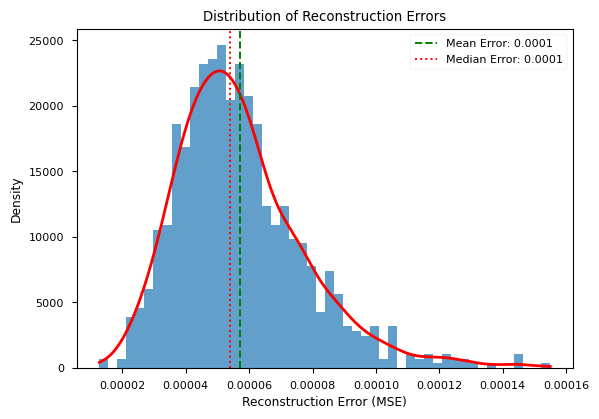

Mean Reconstruction Error: 0.0001
Median Reconstruction Error: 0.0001
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0002


In [13]:
analyze_reconstruction_error(model_conv, data, n_samples=10000)

In [14]:
latents, reconstructed = model_conv.predict(data)
data.shape, reconstructed.shape, latents.shape

((1000, 32, 32), (1000, 32, 32), (1000, 256))

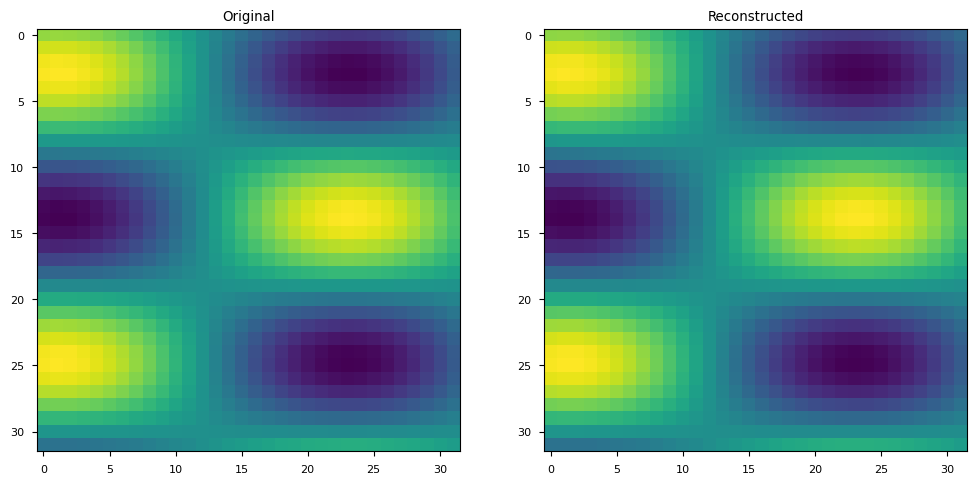

In [15]:
# Plot original and reconstructed signals for a sample
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(data[0], cmap="viridis")
axes[0].set_title("Original")
axes[1].imshow(reconstructed[0], cmap="viridis")
axes[1].set_title("Reconstructed")
plt.show()

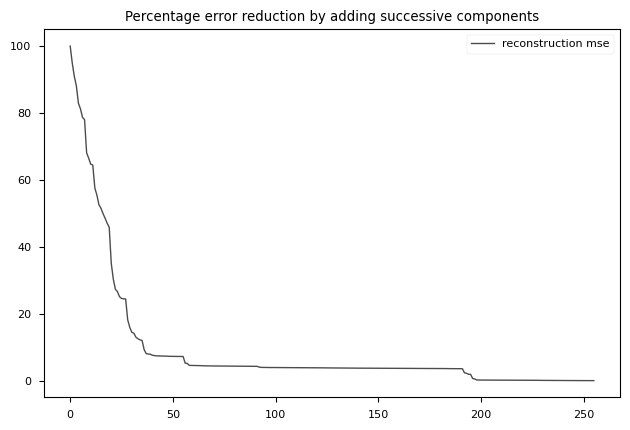

In [16]:
plot_cumsum_variance(model_conv, data)

In [17]:
analyze_latent_space(model_conv, data=data)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 256
Total variance in latent space: 1700.3125

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.4329
First 5 components              0.9991
Components for 95% variance     4
Variance Concentration Metric   0.9962

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Orthogonality Analysis
------------------------------
Metric                                 Value
-----------------------------------  -------
Mean absolute off-diagonal            0.0065
Median absolute off-diagonal          0.0045
Max absolute off-diagonal             0.4165
Proportion of |Orthogonality| > 0.1   0.0018
Orthogonality Success Metric          0.9935

Orthogonality Interpretation:
Excellent orthogonality of featur


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: 0.0001
    - Max cosine similarity: 0.3528
    - Min cosine similarity: -0.2839
    


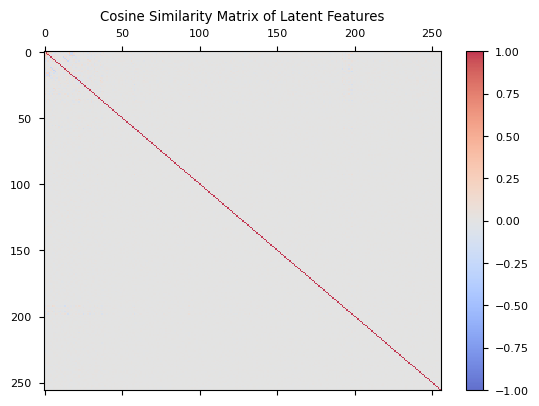

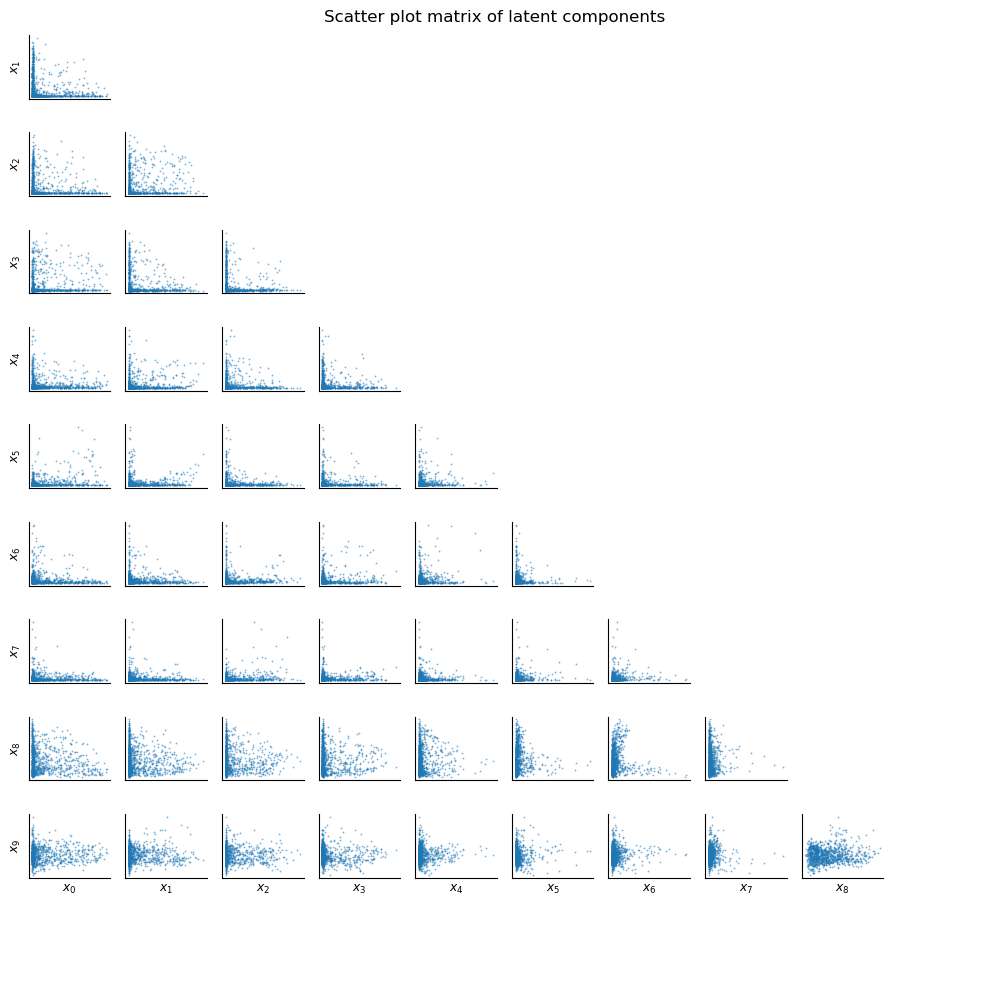

In [18]:
orthogonality_test_analysis(model_conv, data)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.9761
    - Variance fit to exponential distribution (sum of squared differences):
     0.0567
    


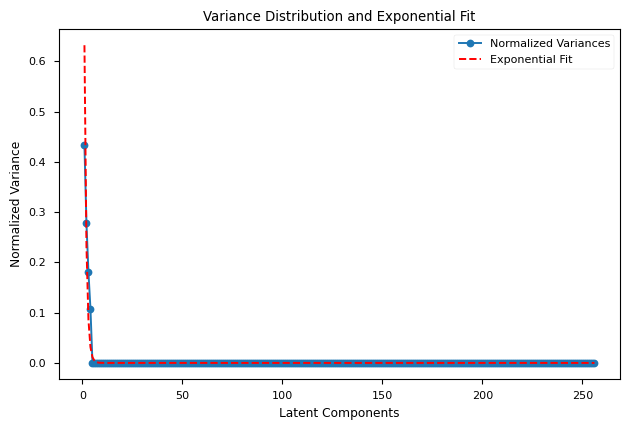

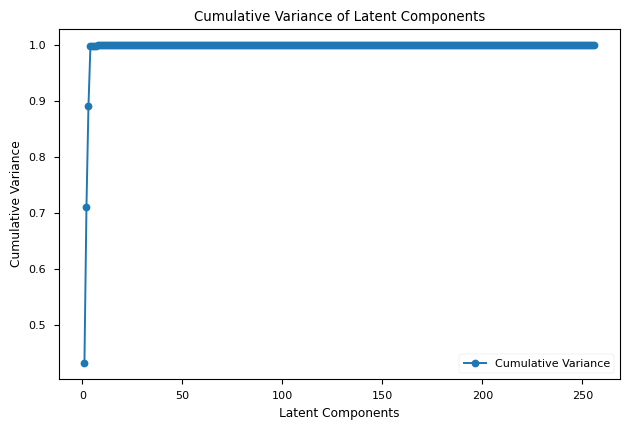

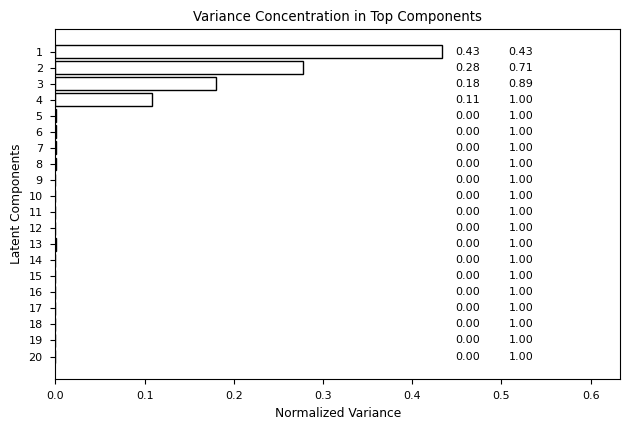

In [19]:
variance_test_analysis(model_conv, data)


    Linearity Tests Analysis

    This report analyzes the linearity properties of the autoencoder. We used a sample size of
    100 randomly selected data points for the analysis.

    The linearity properties of the features are assessed through two tests: additive property
    and homogeneity property. The results are summarized below:

    1. Additive Property:
    ---------------------
    The additive property is tested to verify if:

    f(z_x + z_y) = f(z_x) + f(z_y)

    The differences between the left-hand side and the right-hand side of the equation are
    summarized below:

    - Mean difference: 0.0613
    - Max difference: 0.3817
    - Min difference: 0.0000

    2. Homogeneity Property (Scalar alpha):
    ---------------------------------------
    The homogeneity property is tested to verify if:

    f(a.z_x) = a.f(z_x_)

    The differences between the left-hand side and the right-hand side of the equation are
    summarized below:

    - Mean difference: 0.0357
   

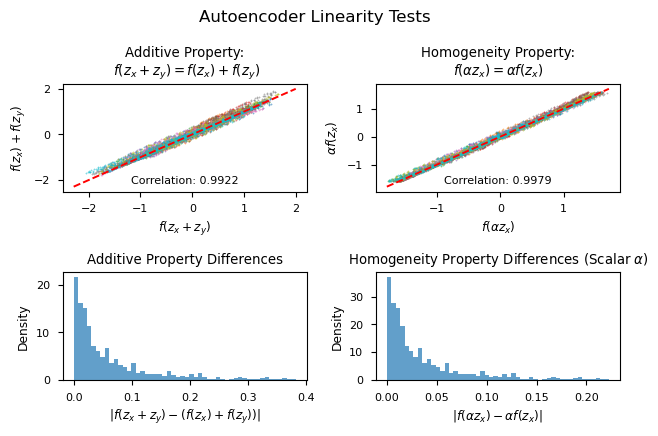

In [20]:
linearity_tests_analysis(model_conv, data)